In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
np.random.seed(0)

In [2]:
train = np.load('./data/train/train_dataset.npy')
labels = np.load('./data/train/labels.npy')
#train_inc_angle = np.load('./data/train/inc_angle.npy')

In [3]:
test_dataset = np.load('./data/test/train_dataset.npy')
test_ids = np.load('./data/test/ids.npy')

In [4]:
# Scaling data to standard mean and variance.
scaler = StandardScaler()
train[:,:,:,0] = scaler.fit_transform(train[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
test_dataset[:,:,:,0] = scaler.transform(test_dataset[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)

train[:,:,:,1] = scaler.fit_transform(train[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
test_dataset[:,:,:,1] = scaler.fit_transform(test_dataset[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)

print train.shape, test_dataset.shape

(1604, 75, 75, 2) (8424, 75, 75, 2)


In [5]:
# getting validation set
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train, labels, test_size=.1)


print train_dataset.shape, train_labels.shape
print valid_dataset.shape, valid_labels.shape

del train, labels

(1443, 75, 75, 2) (1443, 1)
(161, 75, 75, 2) (161, 1)


 ** An iceberg


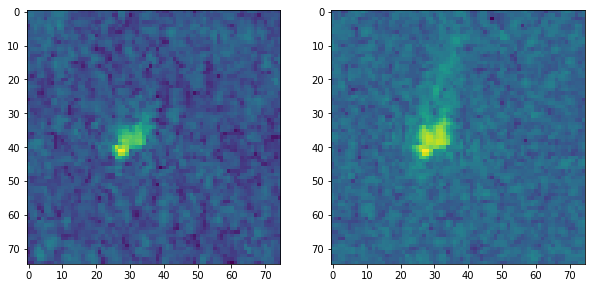

In [6]:
plt.rcParams["figure.figsize"] = [10,6]
index = np.random.randint(0, train_dataset.shape[0])

f, axarr = plt.subplots(1,2)
_ = axarr[0].imshow(train_dataset[index,:,:,0])
_ = axarr[1].imshow(train_dataset[index,:,:,1])

print " ** A ship" if train_labels[index,0] == 1 else " ** An iceberg"

In [7]:
def extract_batch(i):
    
    start_idx = (i * batch_size) % (train_dataset.shape[0] - batch_size )
    end_idx = start_idx + batch_size
    batch_data = train_dataset[ start_idx : end_idx ]
    batch_labels = train_labels[ start_idx : end_idx ]
    
    return batch_data, batch_labels.astype(np.float32)

In [28]:
def create_placeholders(n_H, n_W, n_C, n_y, name1='X', name2='Y'):
    '''
    Create X and Y placeholder, ready for each minibatch
    input : 
        n_H : height of input image
        n_W : width of input image
        n_C : number of channels per image
        n_y  : number of classes
    '''
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name1)
    Y = tf.placeholder(tf.float32, [None, n_y], name2)
    
    return X,Y

In [29]:
def initialize_parameters(weight_shape, bias_shape=None):
    W = tf.get_variable("W", weight_shape, initializer=tf.contrib.layers.xavier_initializer(seed=0))
    return W, None

In [48]:
def inference(X):
    
    with tf.variable_scope("layer_1"):
        # Conv layer
        # weight size : [ filter_size, filter_size, X_n_channel, n_filters ]
        W,_ = initialize_parameters([4,4,2,8])
        # Conv2D stride:1, padding: 'SAME'
        Z1 = tf.nn.conv2d(X, W, [1,1,1,1], 'SAME')
        # relu layer
        A1 = tf.nn.relu(Z1)
        # Max-pooling: window : 8x8, stride:8, padding:'SAME'
        P1 = tf.nn.max_pool(A1,[1,8,8,1], [1,8,8,1], 'SAME')
    
    with tf.variable_scope("layer_2"):
        # Conv layer
        # weight size : [ filter_size, filter_size, old_n_filters, n_filters ]
        W,_ = initialize_parameters([2,2,8,16])
        # conv2D stride:1, padding:'SAME'
        Z2 = tf.nn.conv2d(P1, W, [1,1,1,1], 'SAME')
        # relu layer
        A2 = tf.nn.relu(Z2)
        # Max-pooling, window:4x4, stride:4, padding:'SAME'
        P2 = tf.nn.max_pool(A2, [1,4,4,1], [1,4,4,1], 'SAME')
        
        
    with tf.variable_scope("layer_3"):
        # FC layer
        # Flatten
        P2 = tf.contrib.layers.flatten(P2)
        # 1 neuron is output layer
        Z3 = tf.contrib.layers.fully_connected(P2, 1, activation_fn=None)
        
    return Z3

In [49]:
def compute_loss(Z, Y):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z, labels=Y))
    return loss

In [50]:
def optimize(loss, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(loss, global_step=global_step) 
    return optimizer

In [51]:
def get_summary(loss, tf_valid_loss):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('valid_loss', tf_valid_loss)
    return tf.summary.merge_all()

In [58]:
def predict_test():
    f = open('./data/submission.csv', 'wb')
    f.write('id,is_iceberg\n')
    print "\npredicting test dataset"
    for sind in range(0,test_dataset.shape[0], 2000) :
        print "step ", sind/2000, ' ....'
        #-----------------------------------
        eind = sind + 2000
        if eind > test_dataset.shape[0] :
            eind = test_dataset.shape[0]
         #--------------------------------------   
        test_pred = sess.run([tf_test_pred], feed_dict={X_test : test_dataset[sind:eind]})
        for e1, e2 in zip(test_ids[sind:eind], test_pred[0]):
            f.write('{},{}\n'.format(e1,e2[0]))
    f.close()
    print "finished predicting\n"
    return

In [59]:
# Defining Model graph :
learning_rate = 0.001
n_H, n_W, n_C = train_dataset.shape[1:]
n_y = train_labels.shape[1]

graph = tf.Graph()
with graph.as_default():
    
    with tf.variable_scope('input_data'):
        X, Y = create_placeholders(n_H, n_W, n_C, n_y)
        X_valid, Y_valid = create_placeholders(n_H, n_W, n_C, n_y, 'X_valid', 'Y_valid')
        X_test = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name='X_test')
        
    with tf.variable_scope('forward_propogation', reuse=tf.AUTO_REUSE):
        Z = inference(X)
        Z_valid = inference(X_valid)
        Z_test = inference(X_test)
    
    with tf.variable_scope('loss'):
        tf_loss = compute_loss(Z, Y)
        tf_loss_valid = compute_loss(Z_valid, Y_valid)
    
    with tf.variable_scope('training'):
        global_step = tf.Variable(0, name='global_step',trainable=False)
        optimizer = optimize(tf_loss, global_step)
    
    with tf.variable_scope('summary'):
        summary = get_summary(tf_loss, tf_loss_valid)
    
    with tf.variable_scope('model_saver'):
        saver = tf.train.Saver()
    
    with tf.variable_scope('test_predictions'):
        tf_test_pred = tf.sigmoid(Z_test)
    

In [61]:
# defining Session to run all the above.
avg_loss = 0
display_step = 50
saving_step = 500
batch_size = 64
epoches = 2000



with tf.Session(graph=graph) as sess:
    
    tf.global_variables_initializer().run()

    summary_writer = tf.summary.FileWriter('./tmp/logs/', sess.graph)
    
    for i in range(epoches):
        
        batch_data, batch_labels = extract_batch(i)
        feed_dict = { X : batch_data, Y : batch_labels }
        _, l = sess.run([optimizer, tf_loss], feed_dict=feed_dict)
        avg_loss += l
        
        if i % display_step == 0 :
            avg_loss /= display_step
            
            feed_dict[X_valid] = valid_dataset
            feed_dict[Y_valid] = valid_labels
            summary_str, valid_loss = sess.run([summary,tf_loss_valid], feed_dict=feed_dict)
            _ = summary_writer.add_summary(summary_str, sess.run(global_step))
           
            print "Finished ", i, " steps,\t loss : ", avg_loss, ",\t valid loss : ", valid_loss
            avg_loss = 0
            
        #if i % saving_step == 0:
        #    _ = saver.save(sess, './tmp/model_checkpoints/model-checkpoint', global_step=global_step)
    # predict test_data
    predict_test()
    

Finished  0  steps,	 loss :  0.0188132035732 ,	 valid loss :  0.775646
Finished  50  steps,	 loss :  0.641138504744 ,	 valid loss :  0.58033
Finished  100  steps,	 loss :  0.566093224883 ,	 valid loss :  0.514293
Finished  150  steps,	 loss :  0.508243324757 ,	 valid loss :  0.465835
Finished  200  steps,	 loss :  0.458122478127 ,	 valid loss :  0.428691
Finished  250  steps,	 loss :  0.411535536647 ,	 valid loss :  0.407914
Finished  300  steps,	 loss :  0.383485880494 ,	 valid loss :  0.386829
Finished  350  steps,	 loss :  0.368192787766 ,	 valid loss :  0.374176
Finished  400  steps,	 loss :  0.351444990039 ,	 valid loss :  0.36249
Finished  450  steps,	 loss :  0.337314170599 ,	 valid loss :  0.362824
Finished  500  steps,	 loss :  0.324530853927 ,	 valid loss :  0.350662
Finished  550  steps,	 loss :  0.320737561882 ,	 valid loss :  0.34696
Finished  600  steps,	 loss :  0.312500158846 ,	 valid loss :  0.363176
Finished  650  steps,	 loss :  0.304105120897 ,	 valid loss :  0.3405